# Projeto FarmTech

## Imports

In [153]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Carregar Dados

In [115]:
file_path = 'src/base.csv'
df = pd.read_csv(file_path)

## Análise Exploratória

In [116]:
print("Visualização dos dados:")
display(df.head())

Visualização dos dados:


,data,umidade,nutrientes,irrigacao
0,2023-01-01 00:00:00,10.0,5.0,1
1,2023-01-01 01:00:00,90.0,5.0,1
2,2023-01-01 02:00:00,10.0,50.0,1
3,2023-01-01 03:00:00,90.0,50.0,0
4,2023-01-01 04:00:00,10.0,5.0,1


In [117]:
print("Verificando valores nulos:")
display(df.isnull().sum())

Verificando valores nulos:


data          0
umidade       0
nutrientes    0
irrigacao     0
dtype: int64

In [118]:
print("Informação sobre os dados:")
display(df.info())

Informação sobre os dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   data        1000 non-null   object 
 1   umidade     1000 non-null   float64
 2   nutrientes  1000 non-null   float64
 3   irrigacao   1000 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 31.4+ KB


None

In [119]:
print("Estatísticas descritivas:")
display(df.describe())

Estatísticas descritivas:


,umidade,nutrientes,irrigacao
count,1000.000000,1000.000000,1000.000000
mean,49.988440,20.065250,0.280000
std,10.548398,5.472516,0.449224
min,10.000000,5.000000,0.000000
25%,43.337500,16.522500,0.000000
50%,50.180000,20.115000,0.000000
75%,56.460000,23.285000,1.000000
max,90.000000,50.000000,1.000000


Distribuição da variável Umidade


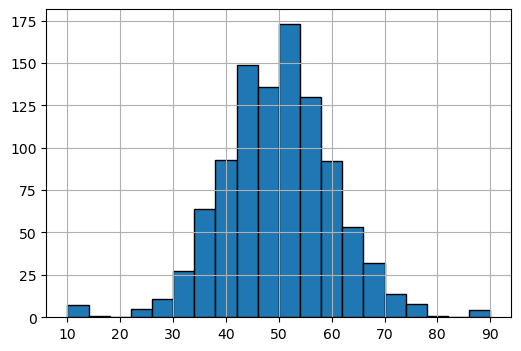

In [120]:
print("Distribuição da variável Umidade")
df['umidade'].hist(bins=20, edgecolor='black', figsize=(6, 4));

Distribuição da variável Nutrientes


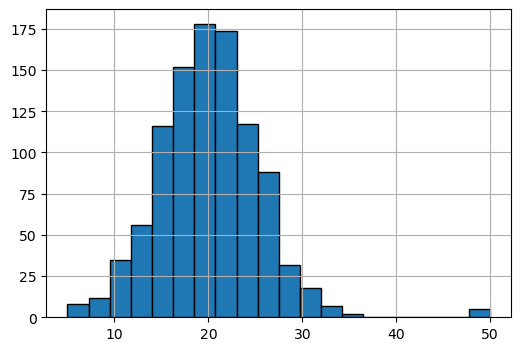

In [121]:
print("Distribuição da variável Nutrientes")
df['nutrientes'].hist(bins=20, edgecolor='black', figsize=(6, 4));

Balancemento da variável Irrigação


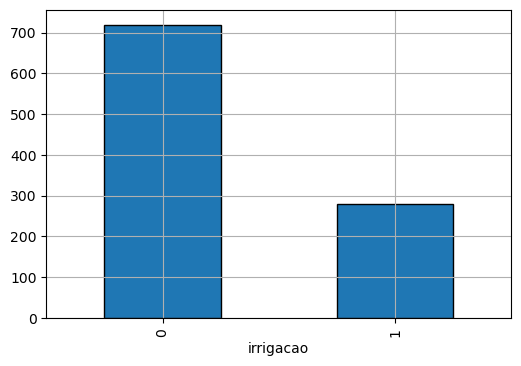

In [122]:
print("Balancemento da variável Irrigação")
df['irrigacao'].value_counts().plot(kind='bar', figsize=(6, 4), edgecolor='black', grid=True);

## ETL

In [123]:
def tratar_outliers(df_temp, variavel):
    Q1 = df_temp[variavel].quantile(0.25)
    Q3 = df_temp[variavel].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_temp[variavel] = np.where(df_temp[variavel] < lower_bound, lower_bound, df_temp[variavel])
    df_temp[variavel] = np.where(df_temp[variavel] > upper_bound, upper_bound, df_temp[variavel])

    return df_temp

In [124]:
base = df.copy()

base['data'] = pd.to_datetime(base['data'])
base['hora'] = base['data'].dt.hour
base['dia'] = base['data'].dt.weekday     # Retornar um valor inteiro, onde 0 é segunda-feira e 6 é domingo

base.drop(columns=['data'], inplace=True)

base.sample(5)

,umidade,nutrientes,irrigacao,hora,dia
231,52.16,17.33,0,15,1
336,41.75,22.50,0,0,6
220,73.15,27.30,0,4,1
348,42.82,19.85,0,12,6
848,43.62,24.28,0,8,6


Verificando a presença de outliers:


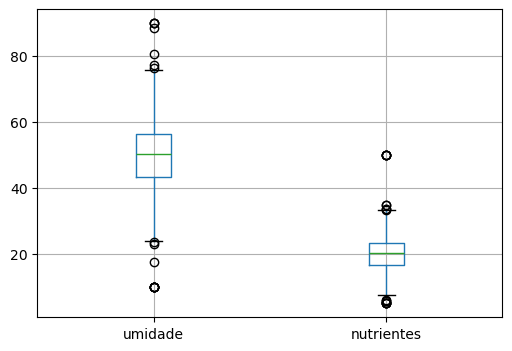

In [125]:
def grafico_boxplot(df_temp):
    print('Verificando a presença de outliers:')
    df_temp[['umidade','nutrientes']].boxplot(figsize=(6, 4));

grafico_boxplot(base)

Aplicando tratamento de outliers...
Verificando a presença de outliers:


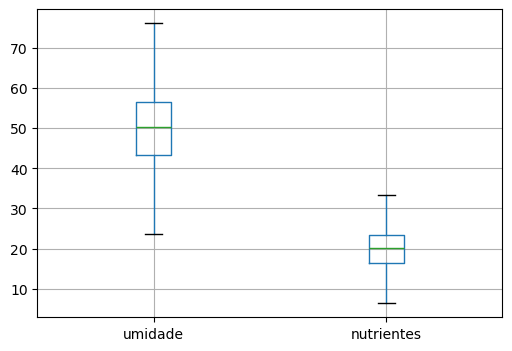

In [126]:
print('Aplicando tratamento de outliers...')
base = tratar_outliers(base, 'nutrientes')
base = tratar_outliers(base, 'umidade')

grafico_boxplot(base)

In [128]:
print('Análise Estatística dos Dados Preparados')
base.describe().transpose()

Análise Estatística dos Dados Preparados


,count,mean,std,min,25%,50%,75%,max
umidade,1000.0,50.031034,10.031810,23.65375,43.3375,50.180,56.460,76.14375
nutrientes,1000.0,19.988048,5.100690,6.37875,16.5225,20.115,23.285,33.42875
irrigacao,1000.0,0.280000,0.449224,0.00000,0.0000,0.000,1.000,1.00000
hora,1000.0,11.436000,6.913009,0.00000,5.0000,11.000,17.000,23.00000
dia,1000.0,2.984000,2.000937,0.00000,1.0000,3.000,5.000,6.00000


## Modelo

In [154]:
X = base.drop(columns=['irrigacao'])
y = base['irrigacao']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # 70% treino e 30% teste

In [155]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Verificar o balanceamento após o SMOTE
print("Distribuição de classes antes do balanceamento:")
print(y_train.value_counts())

print("\nDistribuição de classes após o balanceamento:")
print(pd.Series(y_train_balanced).value_counts())

Distribuição de classes antes do balanceamento:
irrigacao
0    504
1    196
Name: count, dtype: int64

Distribuição de classes após o balanceamento:
irrigacao
0    504
1    504
Name: count, dtype: int64


In [156]:
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

In [157]:
y_pred = modelo.predict(X_test)

### Avaliação dos Resultados

In [164]:
print("\nAcurácia do modelo:", round(accuracy_score(y_test, y_pred) * 100, 2), '%')
print("F1-Score:", f1_score(y_test, y_pred))

print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred))

print("\nDistribuição de classes no conjunto de teste:")
print(y_test.value_counts())


Acurácia do modelo: 100.0 %
F1-Score: 1.0

Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00        84

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


Distribuição de classes no conjunto de teste:
irrigacao
0    216
1     84
Name: count, dtype: int64



Matriz de confusão:


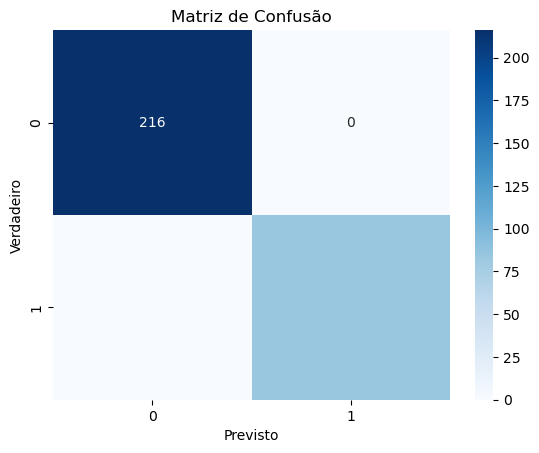

In [163]:
print("\nMatriz de confusão:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()